### In the name of God
### Deep Learning HW5
### Variational Autoencoder



**Name:** Hosna Oyarhoseini

**Std. No.:** 402212503

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
import pickle
import datetime

In [ ]:
import numpy as np
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Variational Autoencoder Model

In [ ]:
class EnocderBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EnocderBlock(color_channels, 32, stride=1, kernel=1, pad=0)
        self.m1 = EnocderBlock(32, 64, stride=1, kernel=3, pad=1)
        self.m2 = EnocderBlock(64, 128, stride=pooling_kernels[0], kernel=3, pad=1)
        self.m3 = EnocderBlock(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)

    def forward(self, x):
        out = self.m3(self.m2(self.m1(self.bottle(x))))
        return out.view(-1, self.n_neurons_in_middle_layer)

class DecoderBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride, activation="relu"):
        super().__init__()
        self.convt = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=stride, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        if activation == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.bn(self.convt(x)))

class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
        self.m1 = DecoderBlock(256, 128, stride=1)
        self.m2 = DecoderBlock(128, 64, stride=pooling_kernels[1])
        self.m3 = DecoderBlock(64, 32, stride=pooling_kernels[0])
        self.bottle = DecoderBlock(32, color_channels, stride=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
        out = self.m3(self.m2(self.m1(out)))
        return self.bottle(out)

class CNN_VAE(nn.Module):
    def __init__(self, dataset):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        super().__init__()
        # # latent features
        self.n_latent_features = 64

        # resolution
        # fashion-mnist : 28 -> 14 -> 7
        pooling_kernel = [2, 2]
        encoder_output_size = 7

        # color channels of fashion-mnist
        color_channels = 1

        # neurons int middle layer
        n_neurons_middle_layer = 256 * encoder_output_size * encoder_output_size

        # Encoder
        self.encoder = Encoder(color_channels, pooling_kernel, n_neurons_middle_layer)

        # Middle
        # form n_neurons_middle_layer to n_latent_features (mean)
        self.fc1 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        # form n_neurons_middle_layer to n_latent_features (log_var)
        self.fc2 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc4 = nn.Linear(self.n_latent_features, n_neurons_middle_layer)

        # Decoder
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)

        # data
        self.train_loader, self.test_loader = self.load_data(dataset)
        # history
        self.history = {"loss":[], "val_loss":[]}

        # model name
        self.model_name = dataset + '_vae'
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(self.device)
        z = mu + std * esp
        return z

    def _bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar

    def sampling(self):
        # assume latent features space ~ N(0, 1)
        z = torch.randn(64, self.n_latent_features).to(self.device)
        z = self.fc4(z)
        # decode
        return self.decoder(z)

    def forward(self, x):
        # Encoder
        h = self.encoder(x)
        # Bottle-neck
        z, mu, logvar = self._bottleneck(h)
        # decoder
        z = self.fc4(z)
        d = self.decoder(z)
        return d, mu, logvar

    # Data
    def load_data(self, dataset):
        data_transform = transforms.Compose([
                transforms.ToTensor()
        ])

        train = FashionMNIST(root="./data", train=True, transform=data_transform, download=True)
        test = FashionMNIST(root="./data", train=False, transform=data_transform, download=True)

        train_loader = torch.utils.data.DataLoader(train, batch_size=126, shuffle=True, num_workers=0)
        test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True, num_workers=0)
        self.classes = train.classes

        return train_loader, test_loader

    # Model
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD

    def init_model(self):
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)

        if self.device == "cuda":
            self = self.cuda()
            torch.backends.cudnn.benchmark=True
        self.to(self.device)

    # Train
    def fit_train(self, epoch):
        self.train()
        print(f"\nEpoch: {epoch+1:d} {datetime.datetime.now()}")
        train_loss = 0
        samples_cnt = 0
        for batch_idx, (inputs, _) in enumerate(self.train_loader):
            inputs = inputs.to(self.device)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self(inputs)

            loss = self.loss_function(recon_batch, inputs, mu, logvar)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            samples_cnt += inputs.size(0)

            if batch_idx%50 == 0:
                print(batch_idx, len(self.train_loader), f"Loss: {train_loss/samples_cnt:f}")

        self.history["loss"].append(train_loss/samples_cnt)

    def test(self, epoch):
        self.eval()
        val_loss = 0
        samples_cnt = 0
        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(self.test_loader):
                inputs = inputs.to(self.device)
                recon_batch, mu, logvar = self(inputs)
                val_loss += self.loss_function(recon_batch, inputs, mu, logvar).item()
                samples_cnt += inputs.size(0)

                if batch_idx == 0:
                    save_image(recon_batch, f"{self.model_name}/reconstruction_epoch_{str(epoch)}.png", nrow=8)

        print(batch_idx, len(self.test_loader), f"ValLoss: {val_loss/samples_cnt:f}")
        self.history["val_loss"].append(val_loss/samples_cnt)

        # sampling
        save_image(self.sampling(), f"{self.model_name}/sampling_epoch_{str(epoch)}.png", nrow=8)

    # save results
    def save_history(self):
        with open(f"{self.model_name}/{self.model_name}_history.dat", "wb") as fp:
            pickle.dump(self.history, fp)


net = CNN_VAE("fashion-mnist")
net.init_model()
# based on your resources you can choose number of epochs from 10 to 40
for i in range(40):
    net.fit_train(i)
    net.test(i)
net.save_history()


Epoch: 1 2024-01-17 12:41:49.942863


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 477 Loss: 638.573103
50 477 Loss: 551.450384
100 477 Loss: 482.085298
150 477 Loss: 452.775824
200 477 Loss: 434.579558
250 477 Loss: 421.294233
300 477 Loss: 410.750748
350 477 Loss: 401.817957
400 477 Loss: 394.303687
450 477 Loss: 387.699357
156 157 ValLoss: 329.780478

Epoch: 2 2024-01-17 12:42:08.736913
0 477 Loss: 334.401228
50 477 Loss: 326.234328
100 477 Loss: 323.205703
150 477 Loss: 320.543902
200 477 Loss: 318.088515
250 477 Loss: 315.920044
300 477 Loss: 314.038008
350 477 Loss: 311.869933
400 477 Loss: 310.000180
450 477 Loss: 308.242136
156 157 ValLoss: 293.254275

Epoch: 3 2024-01-17 12:42:25.955272
0 477 Loss: 285.430990
50 477 Loss: 288.435135
100 477 Loss: 287.955523
150 477 Loss: 287.100893
200 477 Loss: 285.938933
250 477 Loss: 285.048578
300 477 Loss: 283.964237
350 477 Loss: 282.951075
400 477 Loss: 281.986656
450 477 Loss: 281.172110
156 157 ValLoss: 275.558141

Epoch: 4 2024-01-17 12:42:43.124666
0 477 Loss: 270.500186
50 477 Loss: 272.479505
100 477 Loss: 271

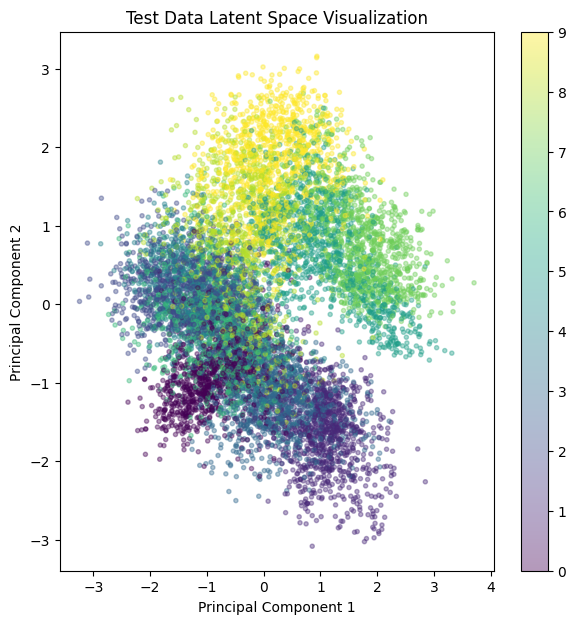

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_test_latent_space(net):
    ########################## TODO ##########################
    # Visualizing test data using latent space features

    # Extracting latent space features for test data
    net.eval()
    test_data_latent_space = []
    test_data_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(net.test_loader):
            inputs = inputs.to(net.device)
            _, mu, _ = net(inputs)
            test_data_latent_space.append(mu.cpu().numpy())
            test_data_labels.append(labels.numpy())

    # Concatenate the lists to get the final arrays
    test_data_latent_space = np.concatenate(test_data_latent_space, axis=0)
    test_data_labels = np.concatenate(test_data_labels, axis=0)
    ######################## ( End ) #########################

    ########################## TODO ##########################
    # Apply PCA with 2 component on test_data_latent_space

    # Apply PCA with 2 components
    pca = PCA(n_components=2)
    pca_test_data = pca.fit_transform(test_data_latent_space)
    ######################## ( End ) #########################

    # Scatter plot latent space
    plt.figure(figsize=(7, 7))
    plt.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c=test_data_labels,
                alpha=.4, s=3**2, cmap='viridis')
    plt.colorbar()
    plt.title('Test Data Latent Space Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

visualize_test_latent_space(net)


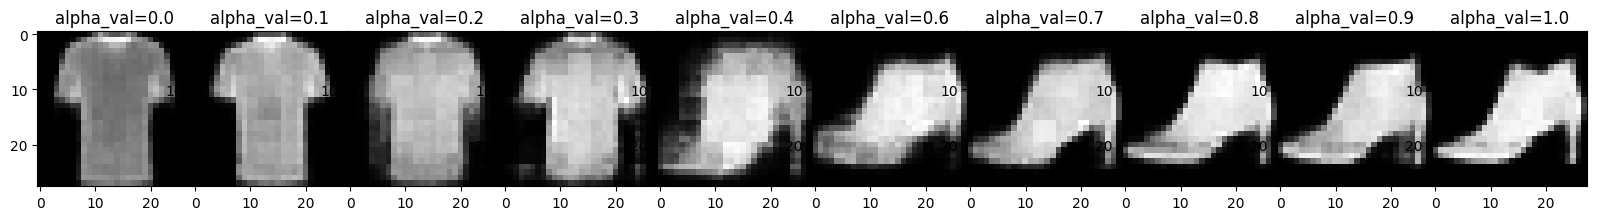

In [ ]:
def interpolation_image(net, img1, img2, alpha):
    with torch.no_grad():
        ########################## TODO ##########################
        # z1 : latent vector of first image
        img1 = img1.to(net.device).unsqueeze(0)
        h1 = net.encoder(img1)
        z1, _, _ = net._bottleneck(h1)

        # z2: latent vector of the second image
        img2 = img2.to(net.device).unsqueeze(0)
        h2 = net.encoder(img2)
        z2, _, _ = net._bottleneck(h2)
        ######################## ( End ) #########################

        # interpolation of the two latent vectors
        inter_latent = alpha* z1 + (1- alpha) * z2

        # reconstruct interpolated image
        inter_latent = net.fc4(inter_latent)
        d = net.decoder(inter_latent)
        inter_image = d.cpu()
        return inter_image


# interpolation alphas
alpha_range=np.linspace(0,1,10)

# select two random img from test_loader
num_test_data = len(net.test_loader.dataset)
img1 = net.test_loader.dataset[random.randint(0, num_test_data)][0]
img2 = net.test_loader.dataset[random.randint(0, num_test_data)][0]

# setup the plot
fig, axs = plt.subplots(1,10, figsize=(20, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for idx,a in enumerate(alpha_range):
    inter_image = interpolation_image(net, img1, img2, float(a))
    image = inter_image.numpy()
    axs[idx].imshow(image[0,0,:,:], cmap='gray')
    axs[idx].set_title('alpha_val='+str(round(a,1)))

plt.show()

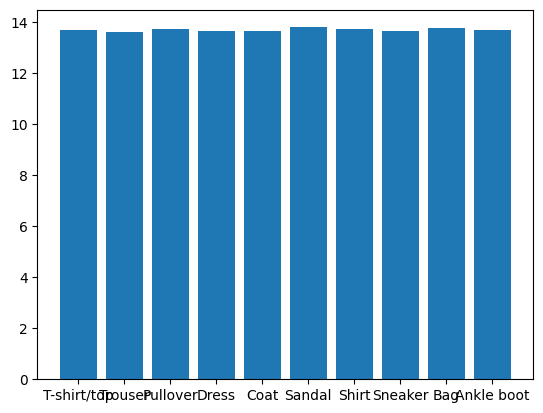

In [ ]:
def plot_reconstruction_error(net):
    net.eval()
    total_reconstruction_error = dict.fromkeys(range(len(net.classes)), 0)
    ########################## TODO ##########################
    # calculate the mean squere error between test image and reconstructed one for all images in test data
    # sum mse values of images in each class
    # total_reconstruction_error[class_n] = sum mse values of images in class_n

    criterion = nn.MSELoss()

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(net.test_loader):
            inputs = inputs.to(net.device)
            recon_batch, _, _ = net(inputs)
            mse = criterion(recon_batch, inputs)

            # Summing up MSE values for each class
            for label in labels:
                total_reconstruction_error[label.item()] += mse.item()

    ######################## ( End ) #########################

    plt.bar(net.classes, total_reconstruction_error.values())

plot_reconstruction_error(net)